In [1]:
from monitor import utc_to_tz
from dateutil import tz
from datetime import datetime
import krakenex
import pymongo
import networkx as nx
import pandas
import numpy as np
import tqdm
import seaborn
from matplotlib import pyplot as plt
import collections

In [2]:
def get_prices(asset_pairs, ticker):
    prices = {}
    for asset_key, asset in asset_pairs.iteritems():
        if asset_key.endswith('.d') or 'DASH' in asset_key:
            continue
        asset_name = asset_key
        base = str(asset['base'])
        quote = str(asset['quote'])
        assert asset_name == base + quote, '%s != %s + %s' % (asset_name, base, quote)
        assert asset_name in ticker, '`%s` not in ticker.' % asset_name
        last_price, last_volume = map(float, ticker[asset_name]['c'])
        assert last_price > 0
        assert (base, quote) not in ticker
        assert (quote, base) not in ticker
        prices[base, quote] = last_price
        prices[quote, base] = 1./last_price
    return prices

In [3]:
k = krakenex.API()
k.load_key('lost.key')
asset_pairs = k.query_public("AssetPairs")['result']

In [4]:
exchange_graph = nx.DiGraph()
fees = {}
for asset_key, asset in asset_pairs.iteritems():
    if asset_key.endswith('.d') or 'DASH' in asset_key:
        continue
    asset_name = asset_key
    base = str(asset['base'])
    quote = str(asset['quote'])
    # assert asset_name == base + quote, '(%s) %s != %s + %s' % (asset_key, asset_name, base, quote)
    assert asset['fees'][0][1] in [0.26, 0.2], '(%s) %.4e != %.4e' % (asset_name, asset['fees'][0][1], 0.26)
    fee = 1-asset['fees'][0][1]/100. 
    fees[base, quote] = fee
    fees[quote, base] = fee
    exchange_graph.add_edge(base, quote)
    exchange_graph.add_edge(quote, base)

In [5]:
cycles = map(tuple, nx.simple_cycles(exchange_graph))
edges = {cycle: tuple(zip(cycle[:-1], cycle[1:]) + [(cycle[-1], cycle[0])]) for cycle in cycles}
currencies_to_cycle = {tuple(sorted(c)): c for c in cycles}
cycles = currencies_to_cycle.values()

In [6]:
# ssh -L 27018:127.0.0.1:27017 klc
client = pymongo.MongoClient(host='localhost', port=27018)
db = client['crypto_market_data']
collection = db['tickers']
# collection.create_index('timestamp')
count = collection.count(with_limit_and_skip=True)
cursor = collection.find().sort([('timestamp', pymongo.ASCENDING)]).limit(count)

In [7]:
docs = [doc for doc in tqdm.tqdm_notebook(cursor, total=count)]

KeyboardInterrupt: 

In [40]:
rows = []
tradable_pairs = exchange_graph.to_undirected().edges()
for doc in tqdm.tqdm_notebook(docs):
    try:
        timestamp = utc_to_tz(doc['timestamp'], tz.gettz('PST'))
        prices = get_prices(asset_pairs, doc['ticker'])
        for cur1, cur2 in tradable_pairs:
            price = prices[cur1,cur2]
            rows.append(dict(timestamp=timestamp, cur1=cur1, cur2=cur2, price=price))
    except AssertionError as e:
        print 'Error on id `%s`.' % doc['_id']
        print str(e)
cur_prices_df = pandas.DataFrame(rows)

Error on id `58ec55ca881dba23d1b5f7af`.
`XXBTZCAD` not in ticker.
Error on id `58ec662f881dba31611372f4`.
`XXBTZCAD` not in ticker.
Error on id `58ec6886881dba316113736b`.
`XXBTZCAD` not in ticker.
Error on id `58ec6911881dba3161137385`.
`XXBTZCAD` not in ticker.
Error on id `58ec69a3881dba3161137391`.
`XZECZUSD` not in ticker.
Error on id `58ec69b0881dba3161137394`.
`XXBTZCAD` not in ticker.
Error on id `58ec69b9881dba3161137396`.
`XXBTZCAD` not in ticker.
Error on id `58ec6c61881dba3161137419`.
`XXBTZCAD` not in ticker.
Error on id `58ec6c77881dba316113741e`.
`XXBTZCAD` not in ticker.
Error on id `58ec6f37881dba316113749a`.
`XXBTZCAD` not in ticker.
Error on id `58ec711f881dba31611374fd`.
`XXBTZCAD` not in ticker.
Error on id `58ec71dc881dba3161137518`.
`XXBTZCAD` not in ticker.
Error on id `58ec71fe881dba3161137520`.
`XXBTZCAD` not in ticker.
Error on id `58ec7207881dba3161137522`.
`XXBTZCAD` not in ticker.
Error on id `58ec74b1881dba3161137596`.
`XXBTZCAD` not in ticker.
Error on i

In [41]:
cur_prices_df

,cur1,cur2,price,timestamp
0,XXMR,ZEUR,2.062388e+01,2017-04-10 21:02:56.633000-07:00
1,XXMR,ZUSD,2.162706e+01,2017-04-10 21:02:56.633000-07:00
2,XXMR,XXBT,1.806000e-02,2017-04-10 21:02:56.633000-07:00
3,XMLN,XETH,6.893100e-01,2017-04-10 21:02:56.633000-07:00
4,XMLN,XXBT,2.480000e-02,2017-04-10 21:02:56.633000-07:00
5,ZGBP,XETH,2.813731e-02,2017-04-10 21:02:56.633000-07:00
6,ZGBP,XXBT,1.049314e-03,2017-04-10 21:02:56.633000-07:00
7,XXBT,ZUSD,1.205100e+03,2017-04-10 21:02:56.633000-07:00
8,XXBT,ZJPY,1.345320e+05,2017-04-10 21:02:56.633000-07:00
9,XXBT,ZEUR,1.133995e+03,2017-04-10 21:02:56.633000-07:00


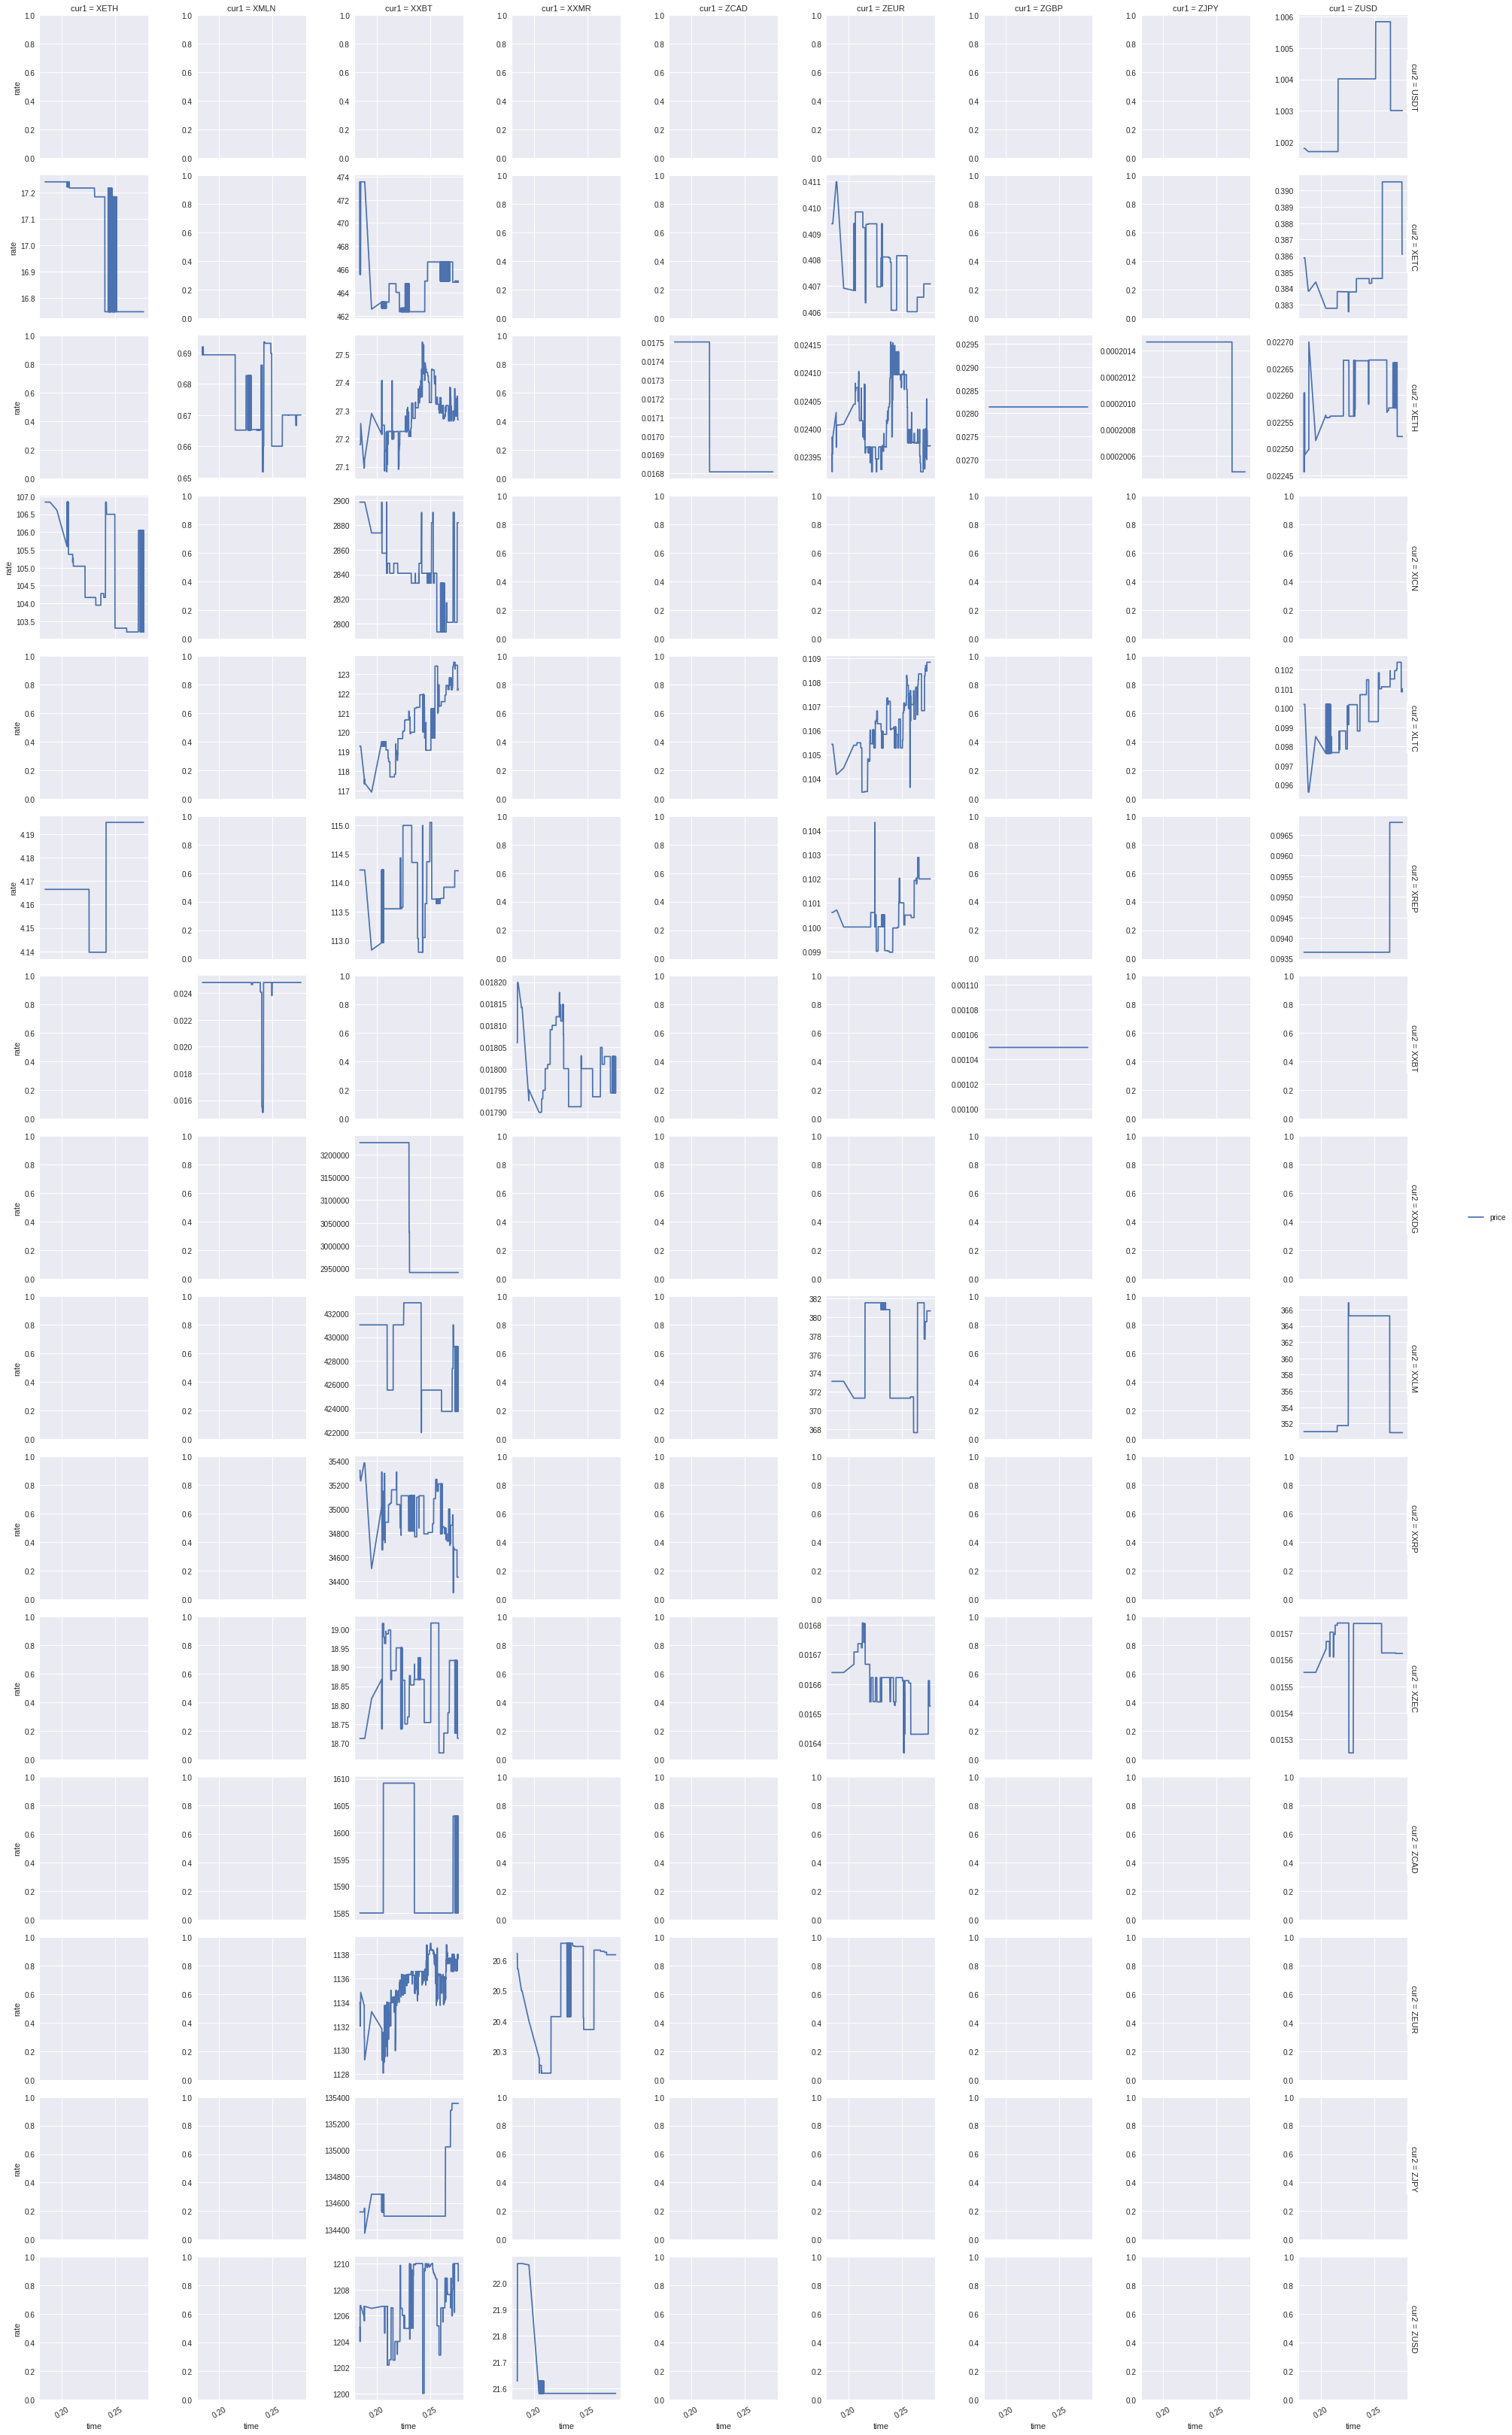

In [50]:
plot_df = cur_prices_df[
    (cur_prices_df['timestamp'] < datetime(2017, 4, 11, 2, tzinfo=tz.gettz('PST')))
]

fg = seaborn.FacetGrid(
    data=plot_df,
    col='cur1',
    col_order=sorted(plot_df['cur1'].unique()),
    row='cur2',
    row_order=sorted(plot_df['cur2'].unique()),
    sharex=True,
    sharey=False,
    margin_titles=True
)
def facet(data, color):
    plt.plot(data['timestamp'], data['price'], color=color)
    
#plt.figure(figsize=(12,12))

fg.map_dataframe(facet)
# for (i, j, k), data in fg.facet_data():
#     if data.empty:
#         ax = fg.facet_axis(i, j)
#         ax.set_axis_off()
    
# max_df = plot_df.groupby('timestamp')['rate'].max().reset_index()
# for (i, j, k), data in fg.facet_data():
#     if k == 0:
#         plt.plot(max_df['timestamp'], max_df['rate'], color='k', label='max', linewidth=1.5)
        
        
fg.set_xticklabels(rotation=30)
fg.add_legend()
# fg.set(yscale='log')
fg.set_xlabels('time')
fg.set_ylabels('rate')
# fg.add_legend()
plt.savefig('cur_prices.png')
plt.show()

In [29]:
rows = []
for doc in tqdm.tqdm_notebook(docs):
    try:
        timestamp = utc_to_tz(doc['timestamp'], tz.gettz('PST'))
        prices = get_prices(asset_pairs, doc['kraken_ticker'])
        for cycle in cycles:
            cycle_edges = edges[cycle]
            for e in cycle_edges:
                if e not in prices:
                    raise ValueError('Edge %s not in prices.' % str(e))
            prod = lambda x,y : x*y
            cycle_fee = reduce(prod, map(fees.get, cycle_edges))
            cycle_price = reduce(prod, map(prices.get, cycle_edges))
            cycle_price = max(cycle_price, 1./cycle_price)
            rate = cycle_fee*cycle_price
            rows.append(dict(timestamp=timestamp, cycle=cycle, rate=rate))
    except AssertionError as e:
        print 'Error on id `%s`.' % doc['_id']
        print str(e)
        
df = pandas.DataFrame(rows)

Error on id `58edad0f881dba631bd50da1`.
`XXBTZCAD` not in ticker.
Error on id `58edad20881dba631bd50da4`.
`XXBTZCAD` not in ticker.
Error on id `58edb09c881dba631bd50e2c`.
`XXBTZCAD` not in ticker.
Error on id `58edb0a1881dba631bd50e2d`.
`XXBTZCAD` not in ticker.
Error on id `58edb476881dba631bd50ebc`.
`XXBTZCAD` not in ticker.
Error on id `58edb47b881dba631bd50ebd`.
`XXBTZCAD` not in ticker.
Error on id `58edb492881dba631bd50ec1`.
`XXBTZCAD` not in ticker.
Error on id `58edb6ad881dba631bd50f1a`.
`XXBTZCAD` not in ticker.
Error on id `58edb7d6881dba631bd50f40`.
`XXBTZCAD` not in ticker.
Error on id `58edbb20881dba631bd50fc2`.
`XXBTZCAD` not in ticker.
Error on id `58edbe61881dba631bd51047`.
`XXBTZCAD` not in ticker.
Error on id `58edbee9881dba631bd51059`.
`XXBTZCAD` not in ticker.
Error on id `58edbeee881dba631bd5105a`.
`XXBTZCAD` not in ticker.
Error on id `58edbf05881dba631bd5105e`.
`XXBTZCAD` not in ticker.
Error on id `58edc1f7881dba631bd510c1`.
`XXBTZCAD` not in ticker.
Error on i

In [30]:
df['length'] = df['cycle'].apply(lambda c: len(c))

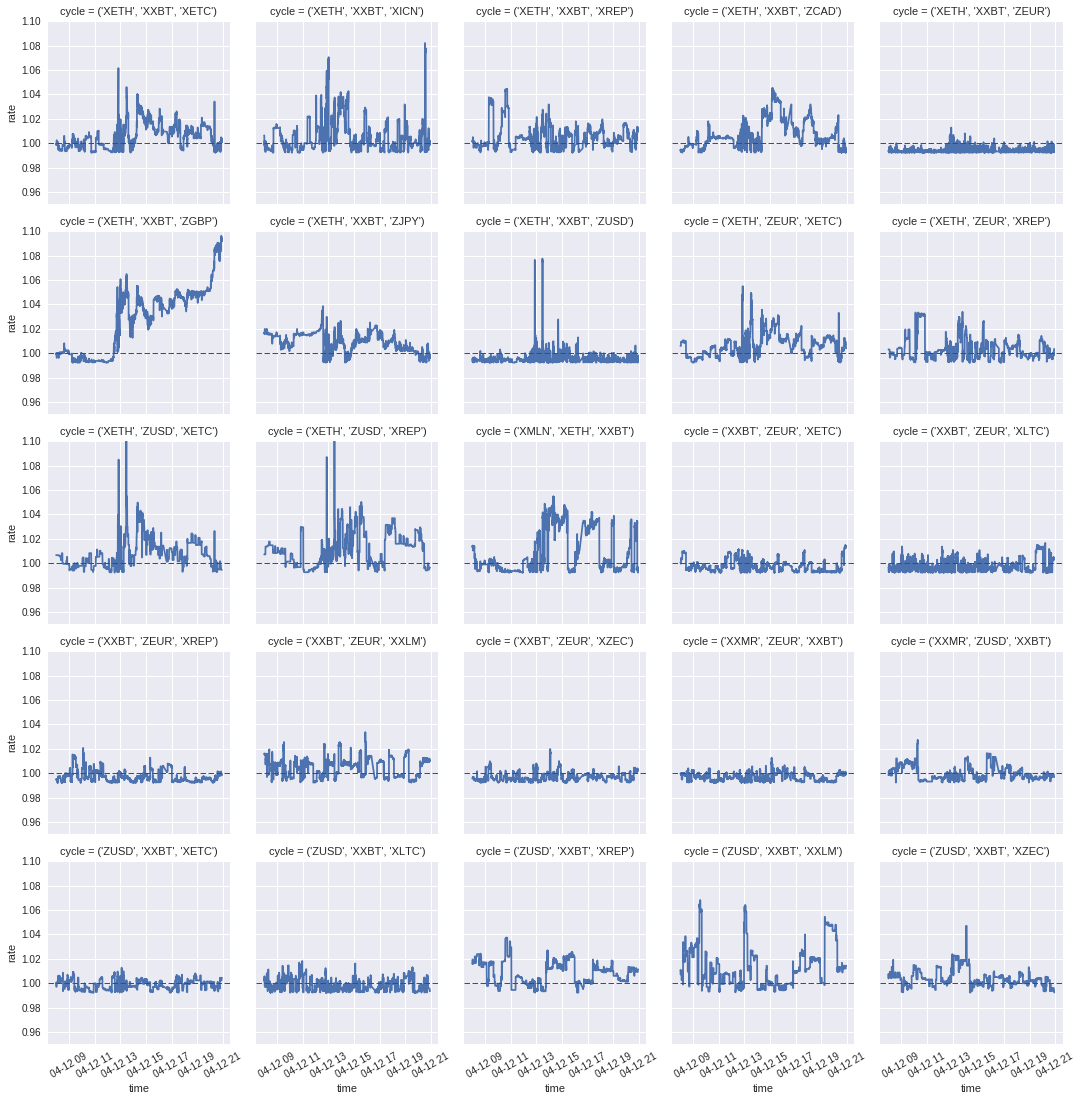

In [35]:
currency = 'XETH'
plot_cycles = [cycle for cycle in cycles if currency in cycle]
plot_cycles = cycles


plot_df = df[
    (df['length']==3) &
    (df['timestamp'] > datetime(2017, 4, 12, 8, tzinfo=tz.gettz('PST'))) &
    # (df['timestamp'] < datetime(2017, 4, 11, 2, tzinfo=tz.gettz('PST'))) &
    (df['cycle'].isin(plot_cycles))
]

fg = seaborn.FacetGrid(
    data=plot_df,
   
    col='cycle',
    col_wrap=5,
    col_order=sorted(plot_df['cycle'].unique()),
    
    # hue='cycle',
    # hue_order=sorte|d(plot_df['cycle'].unique()),
    # size=8,
    # legend_out=True,
    
    sharex=True,
    sharey=True,
    margin_titles=True
)
def facet(data, color):
    plt.plot(data['timestamp'], data['rate'], color=color)
    
#plt.figure(figsize=(12,12))
fg.map_dataframe(facet)
for (i, j, k), data in fg.facet_data():
    if k == 0:
        ax = fg.facet_axis(i, j)
        ax.axhline(y=1.0, linestyle='--', color='r', linewidth=1.)
    
# max_df = plot_df.groupby('timestamp')['rate'].max().reset_index()
# for (i, j, k), data in fg.facet_data():
#     if k == 0:
#         plt.plot(max_df['timestamp'], max_df['rate'], color='k', label='max', linewidth=1.5)
        
        
fg.set_xticklabels(rotation=30)
fg.set(ylim=(0.95,1.1))
fg.set_xlabels('time')
fg.set_ylabels('rate')
# fg.add_legend()
plt.savefig('3cycles-over-time.png')
plt.show()